**Universidad de Ingeniería  y Tecnología (UTEC)**  
Lima, Peru

# Tema de Laboratorio: Classification

**Alumnos**:

1. Leonardo Matías Candio Ormeño

1. Jeffry Hilario Quintana

1. Mauricio Alvarez Julca

## Find a publicly available dataset between 3 and 10 classes, with no more than 1000000 data points, and no less than 1000 data points. You can not use MNIST, but can use derivatives (you can use datasets other than images)

We chose to use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for this project  

## Define your Training Set, Your Validation Set, and Testing Set. How will you partition your data? What is the percentile split? (Example: 80% Training, 10% Validation, 10% Testing) Why did you pick this split

CIFAR-10 provides 50000 specific training images and 10000 testing images. We have also decided to randomly choose 1000 images per class to use as our validation set. As a result, the percentage split is 66.66% training, 16.66% testing and 16.66% validation. 



In [86]:
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression

validation_per_label = 1000

data_labels = {
    0: "airplane",
    1: "truck",
    2: "dog",
}


In [87]:
def get_sets():
    def load_img(_img_label, _img_position, _img_type):
        data_path = "../data"
        return np.array(Image.open(
            f'{data_path}/{"train" if _img_type in ["validation", "train"] else "test"}/{data_labels[_img_label]}/{_img_position:04d}.png')).flatten()

    validation = {_label: set(np.random.permutation(np.arange(1, 5001))[:validation_per_label].flatten()) for _label
                  in range(3)}
    train = {_label: {_img for _img in [i for i in range(1, 5001)] if _img not in validation[_label]} for _label in
             range(3)}
    test = {_label: {_img for _img in range(1, 1001)} for _label in range(3)}

    _validation_set = []
    _train_set = []
    _test_set = []

    for key, value in validation.items():
        for image in value:
            _validation_set.append((load_img(key, image, "validation"), key))

    for key, value in train.items():
        for image in value:
            _train_set.append((load_img(key, image, "train"), key))

    for key, value in test.items():
        for image in value:
            _test_set.append((load_img(key, image, "test"), key))

    random.shuffle(_validation_set)
    random.shuffle(_train_set)
    random.shuffle(_test_set)

    _train_images, _train_labels = zip(*_train_set)
    _validation_images, _validation_labels = zip(*_validation_set)
    _test_images, _test_labels = zip(*_test_set)

    return np.asarray(_train_images), np.asarray(_train_labels), np.asarray(_validation_images), np.asarray(
        _validation_labels), np.asarray(_test_images), np.asarray(_test_labels)


train_images, train_labels, validation_images, validation_labels, test_images, test_labels = get_sets()

Regression without regularization

In [88]:
model = LogisticRegression(n_jobs=2, max_iter=1000, solver='saga', multi_class='multinomial')

In [89]:
model.fit(train_images, train_labels)

/Users/leonardocandio/.conda/envs/lab2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=2,
                   solver='saga')

In [90]:

predicted_labels = model.predict(validation_images)

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

accuracy_score(validation_labels, predicted_labels)

0.706

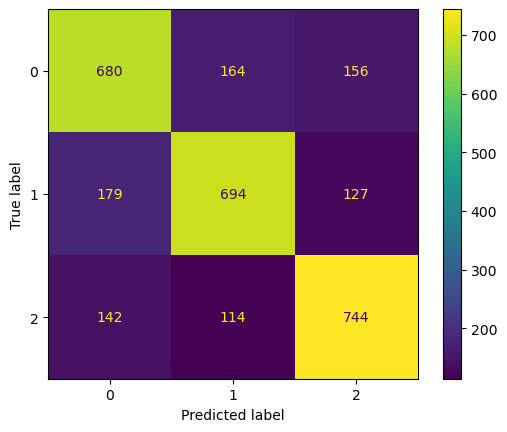

In [92]:
cm = confusion_matrix(validation_labels, predicted_labels)
ConfusionMatrixDisplay(cm).plot()